### 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import stats
from scipy.optimize import minimize

### 전처리  

 
+ 모든 섹터가 있는 2010년 8월 19일부터 2020년 7월 31일 까지만 사용
<br>
<br>
+ 일자별 수익률 사용

In [2]:
raw = pd.read_csv("REITS1.csv")

#SRVR은 범위가 좀 다르게 들어가 있다. 인덱스 확인
print(raw[raw.iloc[:,0] == '2010-08-19'].index)
print(raw[raw.iloc[:,0] == '2020-07-31'].index)

Int64Index([159], dtype='int64')
Int64Index([2663], dtype='int64')


In [3]:
#SRVRSCRTR만 추출 병합을 위하여 인덱스를 맞추기
SRVR = raw['SRVRSCTR'].iloc[159:2664]
SRVR.index = list(range(1,2506))

In [4]:
#나머지도 범위 맞춰 추출
print(raw[raw.iloc[:,2] == '2020-07-31'].index)
left = raw[['Date.1', 'RTLSCTR', 'INDSSCTR', 'PADSCTR', 'RXRE', 'DESK', 'HOTL']]
left_ = left.iloc[1:2506]

Int64Index([2505], dtype='int64')


In [5]:
#SRVR과 병합
left_['SRVRSCTR']=SRVR
reits_data = left_
reits_data

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date.1,RTLSCTR,INDSSCTR,PADSCTR,RXRE,DESK,HOTL,SRVRSCTR
1,2010-08-19,449.87,272.67,396.67,428.39,535.81,333.65,301.85
2,2010-08-20,447.67,272.46,397.25,429.16,534.77,331.03,301.59
3,2010-08-23,444.86,270.03,395.06,427.60,534.97,327.16,298.04
4,2010-08-24,443.68,268.04,394.29,425.83,532.78,319.67,294.48
5,2010-08-25,452.41,273.55,402.17,432.88,543.88,324.36,298.01
...,...,...,...,...,...,...,...,...
2501,2020-07-27,630.52,1483.75,1054.64,1026.85,725.78,637.34,1532.23
2502,2020-07-28,650.23,1507.74,1078.38,1054.43,745.22,642.48,1543.31
2503,2020-07-29,661.00,1558.07,1085.41,1080.27,750.44,654.01,1567.00
2504,2020-07-30,652.24,1556.92,1094.08,1075.76,737.03,642.54,1556.44


In [6]:
#리츠의 일자별 리턴
reits_data.index = reits_data.iloc[:,0]
rets = reits_data.iloc[:,1:]
rets = rets.pct_change(1)
rets

,RTLSCTR,INDSSCTR,PADSCTR,RXRE,DESK,HOTL,SRVRSCTR
Date.1,,,,,,,
2010-08-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-20,-0.004890,-0.000770,0.001462,0.001797,-0.001941,-0.007853,-0.000861
2010-08-23,-0.006277,-0.008919,-0.005513,-0.003635,0.000374,-0.011691,-0.011771
2010-08-24,-0.002653,-0.007370,-0.001949,-0.004139,-0.004094,-0.022894,-0.011945
2010-08-25,0.019676,0.020557,0.019985,0.016556,0.020834,0.014671,0.011987
...,...,...,...,...,...,...,...
2020-07-27,0.013193,0.014766,-0.001638,0.006272,0.001103,-0.013314,0.018662
2020-07-28,0.031260,0.016168,0.022510,0.026859,0.026785,0.008065,0.007231
2020-07-29,0.016563,0.033381,0.006519,0.024506,0.007005,0.017946,0.015350


## Risk Parity  
<br>

+ Marginal Risk Contribution과 Risk Contribution<br><br>
    특정 종목의 비중을 한 단위 늘렸을 때 증가하는 포트폴리오의 위험<br>
    전체 포트폴리오위험을 특정 종목의 비중으로 편미분 한 것<br><br>
+ Risk Contribution<br><br>
    MRC * weight로 구하며 전체 포트폴리오에서 차지하는 위험비중<br>
    MRC가 작더라도 비중이 크면, 전체포트폴리오에서 차지하는 위험은 커진다.

In [7]:
#MRC와 RC를 구하기 위해서는 공분산 행렬이 필요하다.
#공분산행렬 계산
covmat = rets.cov()
covmat

,RTLSCTR,INDSSCTR,PADSCTR,RXRE,DESK,HOTL,SRVRSCTR
RTLSCTR,0.000263,0.000187,0.000185,0.000225,0.000207,0.000213,0.000136
INDSSCTR,0.000187,0.000189,0.000165,0.000191,0.000180,0.000166,0.000139
PADSCTR,0.000185,0.000165,0.000181,0.000183,0.000173,0.000155,0.000125
RXRE,0.000225,0.000191,0.000183,0.000250,0.000198,0.000189,0.000141
DESK,0.000207,0.000180,0.000173,0.000198,0.000202,0.000187,0.000134
HOTL,0.000213,0.000166,0.000155,0.000189,0.000187,0.000278,0.000131
SRVRSCTR,0.000136,0.000139,0.000125,0.000141,0.000134,0.000131,0.000145


+ 리스크 패리티의 목적함수<br>
+ 위험 기여도 간의 차이의 제곱합을 최소화한다.
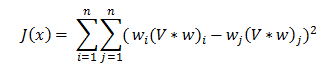  


In [8]:
#여기서부터 코세라 강의에서 나온 코드
#lab24
#https://www.coursera.org/learn/advanced-portfolio-construction-python/lecture/u0D4G/module-4-lab-session-risk-contribution-and-risk-parity

import edhec_risk_kit_206 as erk
#웨이트와 공분산행렬이 주어졌을 때,
#각 자산별 전체 포트폴리오 리스크에 기여하는 비중을 구하는 함수
def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = erk.portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

In [9]:
#타겟 리스크(여기서는 리스크들이 동일하므로 단순히 1/자산종류)와 공분산 행렬이 주어졌을때,
#제약조건 하에서 : 제약조건 1 - 웨이트의 합은 1, 제약조건 2 - 웨이트들은 0과 1사이의 값
#목적함수를 최소화 하는 웨이트를 구하는 함수
def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

In [10]:
#공분산 행렬을 주면 1/자산종류(N)의 값이 N개 들어있는 배열을 만드는 함수
def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)

In [11]:
#공분산 행렬을 넣으면 ERC 포트폴리오의 웨이트를 알려주는 함수
def weight_erc(r, cov_estimator=erk.sample_cov, **kwargs):
    """
    Produces the weights of the ERC portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return equal_risk_contributions(est_cov)

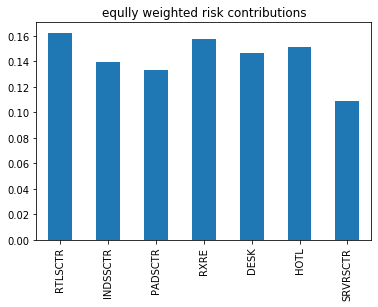

In [12]:
#동일 가중 포트폴리오에서의 섹터별 리스크 컨트리뷰션
risk_contribution(erk.weight_ew(covmat), covmat).plot.bar(title ='eqully weighted risk contributions')

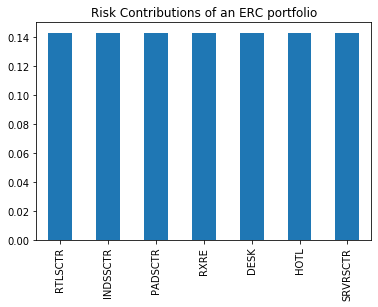

In [13]:
#리스크 패리티 후 리스크 기여도가 동일해진 것을 확인
risk_contribution(equal_risk_contributions(covmat), covmat).plot.bar(title="Risk Contributions of an ERC portfolio");

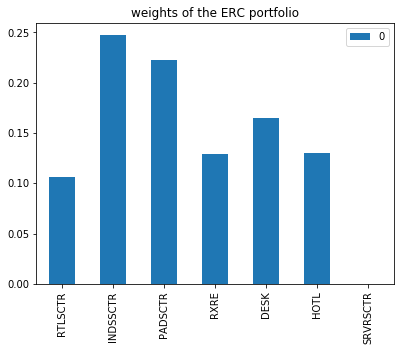

In [14]:
#리스크 패리티 상태에서의 섹터별 가중치
#SRVRSCTR 어디로?
pd.DataFrame(weight_erc(covmat), index=covmat.index).plot.bar(title="weights of the ERC portfolio",  figsize = (6.4, 4.8))

### 백테스팅

동일가중 포트폴리오의 누적 수익률과 비교

In [15]:
#동일 가중 포트폴리오의 수익률
ew_mean_rets = rets.sum(axis=1)/7
ew_mean_rets

Date.1
2010-08-19    0.000000
2010-08-20   -0.001865
2010-08-23   -0.006776
2010-08-24   -0.007863
2010-08-25    0.017752
                ...   
2020-07-27    0.005578
2020-07-28    0.019840
2020-07-29    0.017324
2020-07-30   -0.007475
2020-07-31   -0.006282
Length: 2505, dtype: float64

In [16]:
#리스크 패리티포트폴리오의 수익률
erc_weight = weight_erc(covmat)
erc_rets = rets @ erc_weight
erc_rets

Date.1
2010-08-19         NaN
2010-08-20   -0.001495
2010-08-23   -0.006027
2010-08-24   -0.006732
2010-08-25    0.019098
                ...   
2020-07-27    0.003929
2020-07-28    0.021250
2020-07-29    0.018104
2020-07-30   -0.005581
2020-07-31   -0.005246
Length: 2505, dtype: float64

In [17]:
#EW 이동평균 수익률
#ERC 이평 수익률도 만들어서 비교
ma5 = ew_mean_rets.rolling(window=5).mean()
ma20 = ew_mean_rets.rolling(window=20).mean()
ma60 = ew_mean_rets.rolling(window=60).mean()
ma120 = ew_mean_rets.rolling(window=120).mean()

ew_df = pd.DataFrame()
ew_df['MA5'] = ma5
ew_df['MA20'] = ma20
ew_df['MA60'] = ma60
ew_df['MA120'] = ma120

ew_df.tail()

,MA5,MA20,MA60,MA120
Date.1,,,,
2020-07-27,0.002614,0.001061,0.000687,-0.001334
2020-07-28,0.004712,0.000668,0.001702,-0.001191
2020-07-29,0.004510,0.001272,0.002128,-0.001068
2020-07-30,0.004496,-0.000050,0.001981,-0.001101
2020-07-31,0.005797,-0.000190,0.002214,-0.001246


In [18]:
#리스크 패리티의 이동평균 수익률
#일단은 60일 이동평균 수익률만 비교하기 위해
erc_df = pd.DataFrame()
#erc_df['MA5'] = ma5
#erc_df['MA20'] = ma20
erc_df['MA60'] = erc_rets.rolling(window=60).mean()
#erc_df['MA120'] = ma120

erc_df.tail()

,MA60
Date.1,
2020-07-27,0.000565
2020-07-28,0.001615
2020-07-29,0.002079
2020-07-30,0.001972
2020-07-31,0.002226


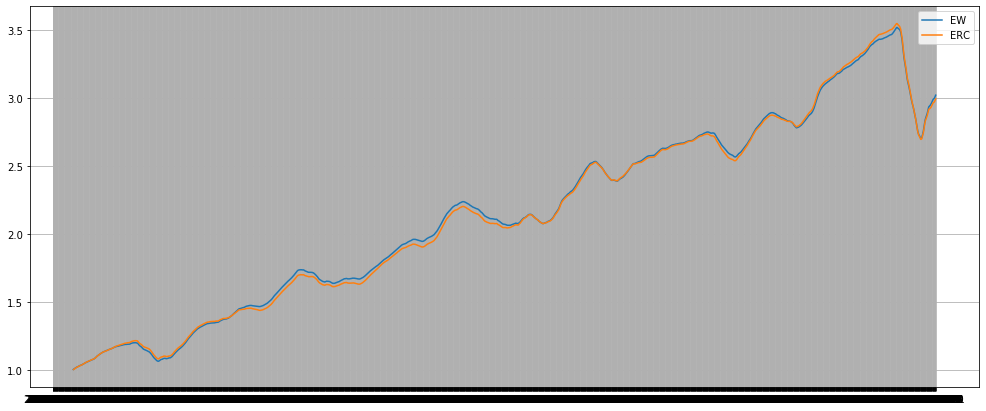

In [19]:
#두 포트폴리오의 60일 이동평균 누적 수익률은 거의 비슷하게 움직이는 것 같다.
plt.rcParams["figure.figsize"] = (17,7)
plt.plot(rets.index, (ew_df['MA60']+1).cumprod(), label='EW')
plt.plot(rets.index, (erc_df['MA60']+1).cumprod(), label='ERC')
plt.legend()
plt.grid()

### 샤프비율 극대화 포트폴리오의 수익률

In [20]:
import edhec_risk_kit_110 as erk

In [21]:
#연수익률 계산을 위해 datetime으로 인덱스를 바꿔준다
rets.index = pd.to_datetime(rets.index, format='%Y-%m-%d', errors='raise')

In [22]:
#연도별 거래일 
for i in range(2011,2020):
    print (str(i) + ' ' + str(len(rets['{}'.format(i)])))

2011 252
2012 250
2013 252
2014 252
2015 252
2016 252
2017 251
2018 251
2019 252


In [23]:
#연수익률. 그냥 거래일 퉁쳐서 252하기로...
#연수익률을 위해 2010년 2020년은 제외시킴
er = erk.annualize_rets(rets['2011':'2019'], 252)
er

RTLSCTR     0.076221
INDSSCTR    0.175516
PADSCTR     0.125142
RXRE        0.113573
DESK        0.068286
HOTL        0.115054
SRVRSCTR    0.167235
dtype: float64

(0, 0.014326116431112597)

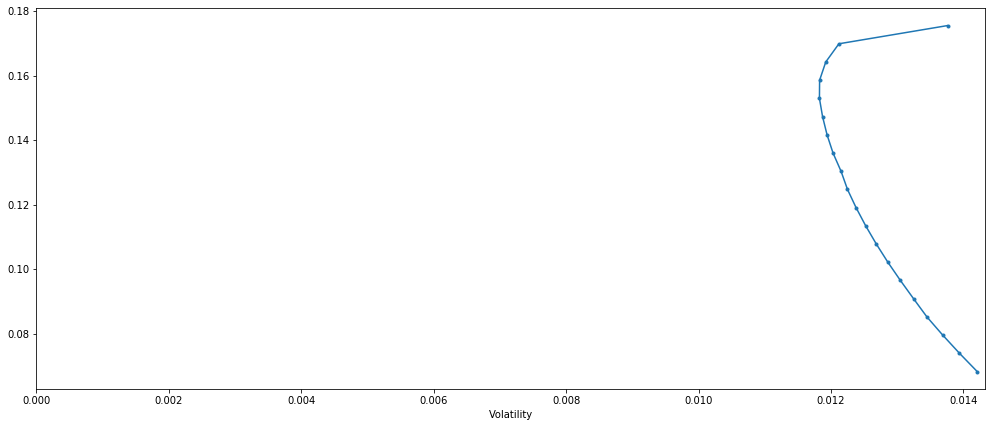

In [24]:
#efficient frontier를 그려보자
ax = erk.plot_ef(20, er, covmat) #20개 점찍으라는 의미
ax.set_xlim(left = 0)

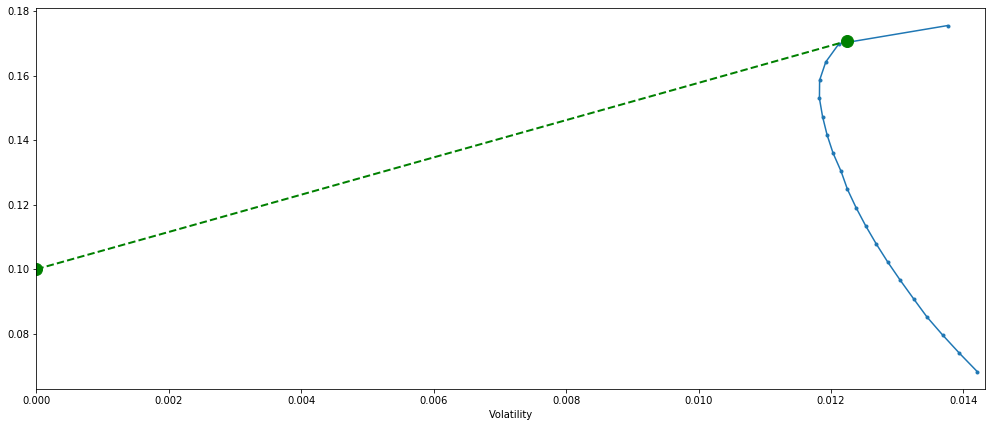

In [25]:
# plot EF
ax = erk.plot_ef(20, er, covmat)
ax.set_xlim(left = 0)
# get MSR
rf = 0.1
w_msr = erk.msr(rf, er, covmat) # 이함수가 샤프비율을 극대화시킨다. 목적함수는 마이너스(-)포트폴리오 샤프로 이 값을 극소화하는 함수이다.
r_msr = erk.portfolio_return(w_msr, er)
vol_msr = erk.portfolio_vol(w_msr, covmat)
# add CML
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]
ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)

[8.52814258e-12 4.19325376e-01 4.86868248e-12 8.39129275e-12
 8.56554185e-12 4.86538227e-12 5.80674624e-01]


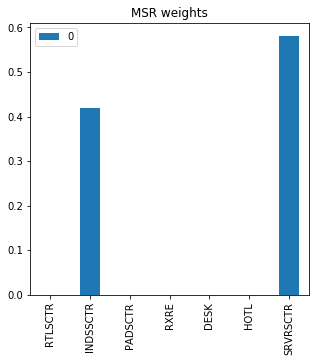

In [26]:
#샤프비율 극대화 포트폴리오의 웨이트
print(w_msr)
plt.rcParams["figure.figsize"] = (5,5)
pd.DataFrame(w_msr, index=covmat.index).plot.bar(title='MSR weights')

In [27]:
msr_rets = rets @ w_msr
msr_rets

Date.1
2010-08-19         NaN
2010-08-20   -0.000823
2010-08-23   -0.010575
2010-08-24   -0.010026
2010-08-25    0.015581
                ...   
2020-07-27    0.017028
2020-07-28    0.010979
2020-07-29    0.022911
2020-07-30   -0.004223
2020-07-31   -0.001407
Length: 2505, dtype: float64

In [28]:
msr_df = pd.DataFrame()
#erc_df['MA5'] = ma5
#erc_df['MA20'] = ma20
msr_df['MA60'] = msr_rets.rolling(window=60).mean()
#erc_df['MA120'] = ma120

msr_df.tail()

,MA60
Date.1,
2020-07-27,0.001969
2020-07-28,0.002603
2020-07-29,0.002964
2020-07-30,0.002759
2020-07-31,0.002795


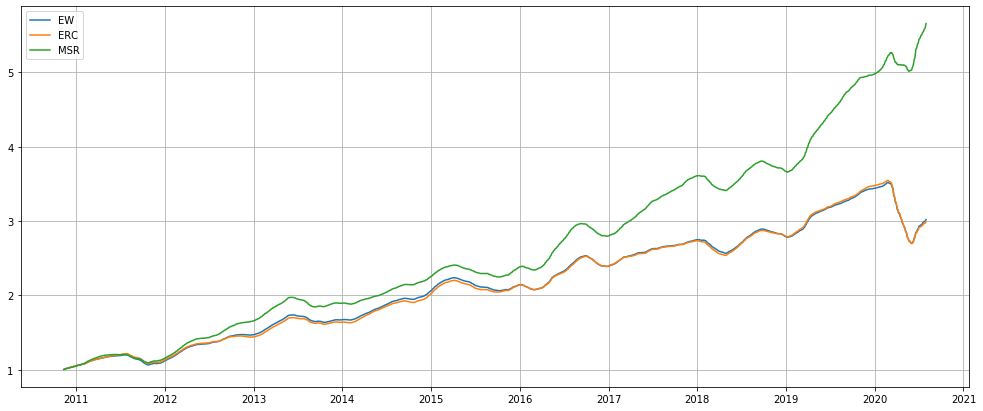

In [29]:
plt.rcParams["figure.figsize"] = (17,7)
plt.plot(rets.index, (ew_df['MA60']+1).cumprod(), label='EW')
plt.plot(rets.index, (erc_df['MA60']+1).cumprod(), label='ERC')
plt.plot(rets.index, (msr_df['MA60']+1).cumprod(), label='MSR')
plt.legend()
plt.grid()


#샤프 비율을 고려해야 된다는 것의 당위성이 생겼다

### 샤프비율 기여도까지 고려하는 Active risk budgeting

t기 RB를 정의하는 식<br>
즉, (개별자산의 샤프/ 개별자산의 샤프 합)이 RB가 된다<br>
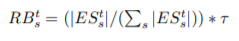

active RB의 목적함수, 제약조건은 리스크 패리티전략과 같으며 RC-RB의 제곱합을 극소화하는 것이다.<br>
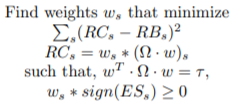

즉 원하는 기간의 RB를 구해 equally weighted weight 대신에 target risk contribution 함수에 넣어주면 위 목적함수를 최소화 하는 것이 된다.

In [33]:
#개별자산의 샤프비율을 구해보자
def sharpe_ratio_s (cov, rets, risk_free_rate):
    variance = np.diag(cov)
    std =  variance ** 0.5
    cum_rets = (1+rets).cumprod().iloc[-1,:]
    sharpe_s =  (cum_rets - risk_free_rate)/std
    
    return sharpe_s

sharpe_s = sharpe_ratio_s (covmat, rets, risk_free_rate=0.1)
sharpe_s

RTLSCTR      81.870985
INDSSCTR    407.006089
PADSCTR     198.032099
RXRE        150.870037
DESK         89.722236
HOTL        107.468307
SRVRSCTR    419.297371
Name: 2020-07-31 00:00:00, dtype: float64

In [35]:
#RB값을 확인
RB =  sharpe_s/(sharpe_s.sum())
RB

RTLSCTR     0.056297
INDSSCTR    0.279870
PADSCTR     0.136173
RXRE        0.103743
DESK        0.061696
HOTL        0.073899
SRVRSCTR    0.288322
Name: 2020-07-31 00:00:00, dtype: float64

[0.04936917 0.26441279 0.13787087 0.09058423 0.05781731 0.0703941
 0.32955153]


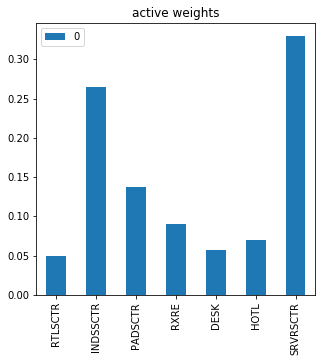

In [36]:
#액티브 RB의 웨이트 
plt.rcParams["figure.figsize"] = (5,5)

#기존 함수에 타겟만 RB로 바꿔주었다.
active_weights = target_risk_contributions(RB, covmat)
pd.DataFrame(active_weights, index = covmat.index).plot.bar(title = 'active weights')
print(active_weights)

In [37]:
active_rets = rets @ active_weights
active_rets

Date.1
2010-08-19         NaN
2010-08-20   -0.001030
2010-08-23   -0.008438
2010-08-24   -0.008508
2010-08-25    0.016850
                ...   
2020-07-27    0.010174
2020-07-28    0.015854
2020-07-29    0.019490
2020-07-30   -0.004615
2020-07-31   -0.003489
Length: 2505, dtype: float64

In [38]:
active_df = pd.DataFrame()
#erc_df['MA5'] = ma5
#erc_df['MA20'] = ma20
active_df['MA60'] = active_rets.rolling(window=60).mean()
#erc_df['MA120'] = ma120

active_df.tail()

,MA60
Date.1,
2020-07-27,0.001256
2020-07-28,0.002088
2020-07-29,0.002454
2020-07-30,0.002295
2020-07-31,0.002443


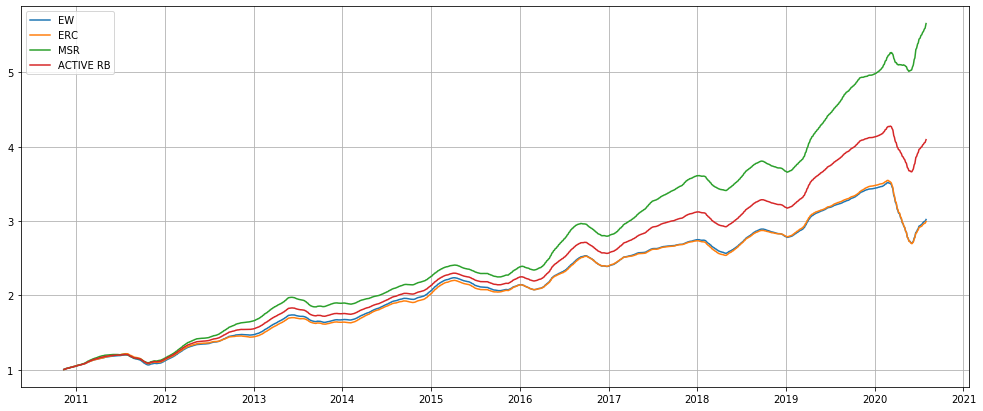

In [39]:
#Active risk budget의 60일 이동평균 수익률
#맥시멈샤프와 리스크 패리티 전략 사이 적절한 중간을 보여준다.
plt.rcParams["figure.figsize"] = (17,7)
plt.plot(rets.index, (ew_df['MA60']+1).cumprod(), label='EW')
plt.plot(rets.index, (erc_df['MA60']+1).cumprod(), label='ERC')
plt.plot(rets.index, (msr_df['MA60']+1).cumprod(), label='MSR')
plt.plot(rets.index, (active_df['MA60']+1).cumprod(), label='ACTIVE RB')
plt.legend()
plt.grid()

### 한계점, 수정사항<br>

+ MSR 연평균 수익률을 구할 때 거래일을 252일로 퉁쳐서 계산했고(실제로는 251일인 년도도 존재), 이때문에 년도도 2012년부터 2019년사이의 것으로 연평균 수익률을 구함<br><br>
+ RC,RB모두 전체기간에 걸쳐서 적용한 것이기 때문에 기간을 나눠서 해야함<br><br>
+ 생존자 편향?